In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import gc
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from copy import deepcopy
from random import shuffle
from scipy.stats import spearmanr

from access_biology_data import lincs, properties
from access_science_shared import standardizer

sys.path.append('./../src/')
from aging_tools import inout, export

from access_biology_data import annotation
from access_biology_data import meta

# Note

here the "no brain" is all samples, including brain

In [4]:
outfolder = '200616_gtex_transcript_imbalance_without_inflammation_and_neurons_all'

In [5]:
save_images = False

In [6]:
ref_genes = standardizer.reference_genes(9606, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [7]:
import glob

In [8]:
p =export.get_material_path(
    '200518_chache_tstoeger_gtex_with_tilt_no_neurons_inflammation/stats_on_imbalance.xlsx')

In [9]:
d = pd.read_excel(p)

In [10]:
d.head()

,condition,tilt,pval,tilt_orp,pval_orp,gender,tissue,younger,older
0,females_Adipose_Subcutaneous_3_vs_2,0.250402,4.148383e-169,0.250402,4.148383e-169,female,Adipose - Subcutaneous,2,3
1,females_Adipose_Subcutaneous_4_vs_2,0.168802,8.505438e-77,0.168802,8.505438e-77,female,Adipose - Subcutaneous,2,4
2,females_Adipose_Subcutaneous_4_vs_3,-0.154478,1.782807e-66,-0.154478,1.782807e-66,female,Adipose - Subcutaneous,3,4
3,females_Adipose_Subcutaneous_5_vs_2,0.079311,3.741772e-18,0.079311,3.741772e-18,female,Adipose - Subcutaneous,2,5
4,females_Adipose_Subcutaneous_5_vs_3,-0.224306,2.309690e-136,-0.224306,2.309690e-136,female,Adipose - Subcutaneous,3,5


In [11]:
d = d.rename(columns={'tilt': 'rho', 'tissue': 'region'})

In [12]:
d['gender'] = d['gender'] + 's'

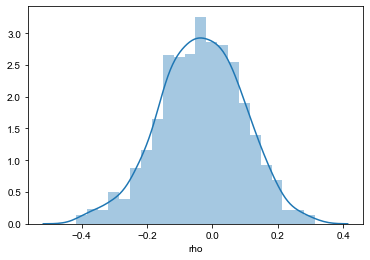

In [13]:
sns.distplot(d['rho'])

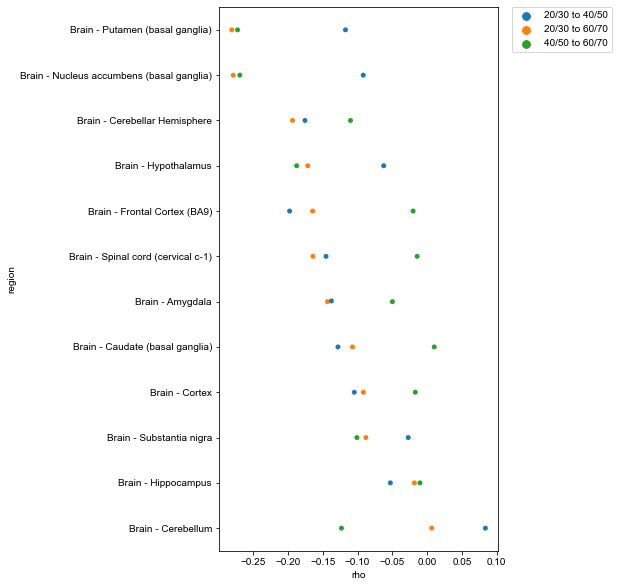

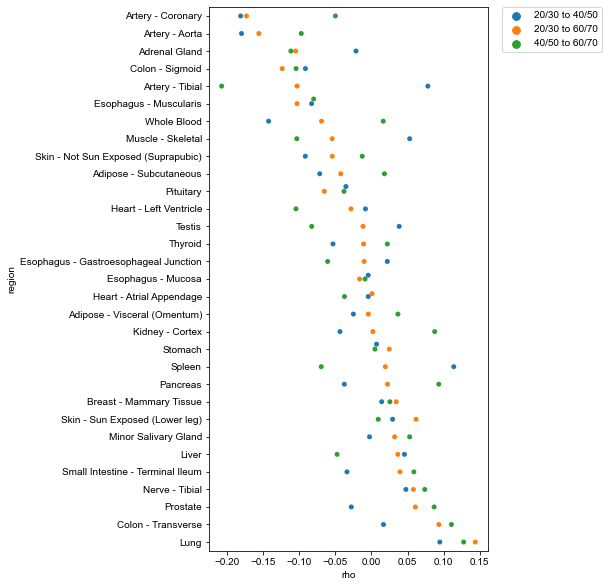

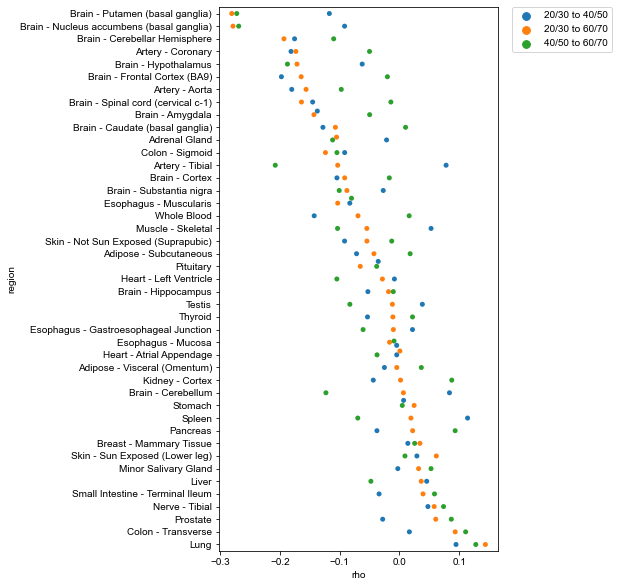

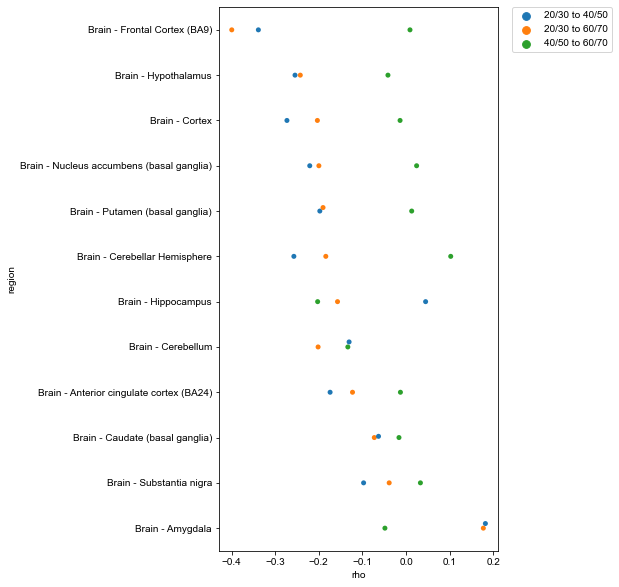

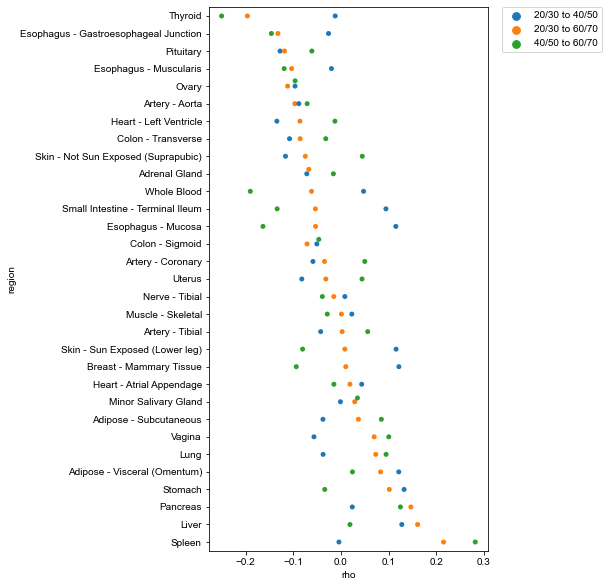

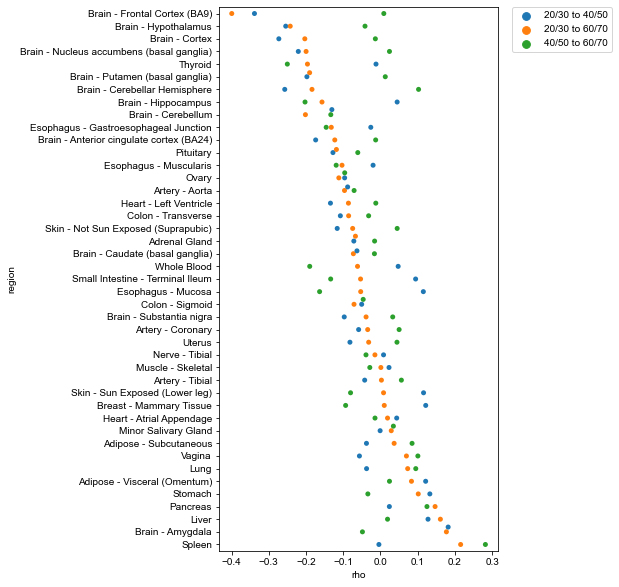

In [14]:
agg = []

for gender in ['males', 'females']:

    s = d[(d['gender']==gender)].copy()

    f = (s['younger'].isin([2, 3]) & s['older'].isin([4, 5]))
    s.loc[f, 'cat'] = '20/30 to 40/50'

    f = (s['younger'].isin([4, 5]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '40/50 to 60/70'

    f = (s['younger'].isin([2, 3]) & s['older'].isin([6, 7]))
    s.loc[f, 'cat'] = '20/30 to 60/70'

    s = s.dropna(subset=['cat'])

    s = s[['pval', 'region', 'cat', 'rho']].groupby(['region', 'cat']).agg(np.median)

    s = s.reset_index()
    comparisons_per_tissue = s['region'].value_counts()
    
    # only consider, if all thre age comparisons are there
    s = s[s['region'].isin(comparisons_per_tissue[comparisons_per_tissue==3].index)]

    order = s[['region', 'rho']].groupby('region').agg(np.median).sort_values('rho')

    hue_order=['20/30 to 40/50','20/30 to 60/70', '40/50 to 60/70', ]

    plt.figure(figsize=(5, 10))
    sns.swarmplot(x='rho', y='region',data=s, hue='cat',
                order=order[order.index.str.startswith('Brain')].index,
                hue_order=hue_order
                 )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_images:
        export.export_image(
            '{}/{}_brain.pdf'.format(
                outfolder,
                gender))

    plt.figure(figsize=(5, 10))
    sns.swarmplot(x='rho', y='region',data=s, hue='cat',
                order=order[~order.index.str.startswith('Brain')].index,
                hue_order=hue_order
                 )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_images:
        export.export_image(
            '{}/{}_non_brain.pdf'.format(
                outfolder,
                gender))

    plt.figure(figsize=(5, 10))
    sns.swarmplot(x='rho', y='region',data=s, hue='cat',
                order=order.index,
                hue_order=hue_order
                 )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if save_images:
        export.export_image(
            '{}/{}_all.pdf'.format(
                outfolder,
                gender))
        
    if save_images:
        export.export_full_frame(
            '{}/{}_all.xlsx'.format(
                    outfolder,
                    gender), 
            s)
        
        export.export_full_frame(
            '{}/{}_young_to_old.xlsx'.format(
                    outfolder,
                    gender), 
            s[s['cat']=='20/30 to 60/70'])  
        
    s.loc[:, 'gender'] = gender
    agg.append(s)

In [15]:
d['younger'].value_counts()

2    375
3    285
4    247
5    158
6     70
Name: younger, dtype: int64

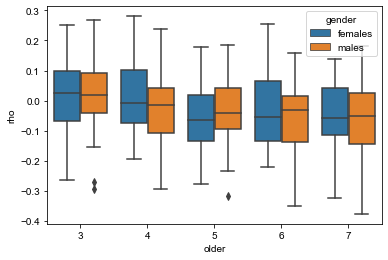

In [16]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[d['younger']==2],
    hue='gender'

)

In [17]:
e = pd.concat(agg)

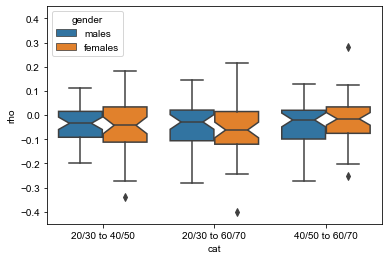

In [18]:
sns.boxplot(x='cat', y='rho', data=e, hue='gender', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_third.pdf'.format(
            outfolder))

In [19]:
a = e.copy()
b = e[e['region'].str.startswith('Brain -')].copy()

a.loc[:, 'is_brain'] = False
b.loc[:, 'is_brain'] = True

e = pd.concat([a, b])

e['is_brain'] = e['is_brain'].astype(float)

In [20]:
# f = e['region'].str.startswith('Brain -')

# e.loc[:, 'is_brain'] = f.astype(float)

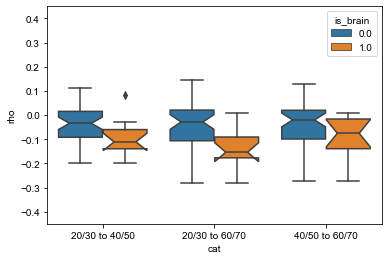

In [21]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='males'], hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_male_brain.pdf'.format(
            outfolder))

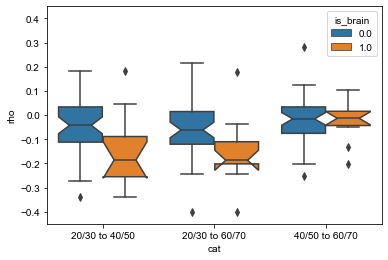

In [22]:
sns.boxplot(x='cat', y='rho', data=e[e['gender']=='females'], hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_female_brain.pdf'.format(
            outfolder))

(-0.45, 0.45)

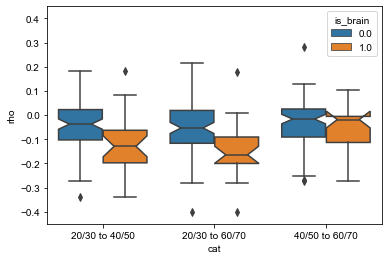

In [23]:
sns.boxplot(x='cat', y='rho', data=e, hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)



In [24]:
from scipy.stats import mannwhitneyu

In [25]:
a = e[
    (e['cat']=='20/30 to 40/50') &
    (e['is_brain']==False)
]['rho']

b = e[
    (e['cat']=='20/30 to 40/50') &
    (e['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=571.0, pvalue=0.0008593365607731589)

In [26]:
a = e[
    (e['cat']=='20/30 to 40/50') &
    (e['is_brain']==False)
]['rho']

b = e[
    (e['cat']=='20/30 to 60/70') &
    (e['is_brain']==True)
]['rho']

mannwhitneyu(b, a, alternative='two-sided')

MannwhitneyuResult(statistic=459.0, pvalue=3.4229522133612964e-05)

In [27]:
m = e[
    (e['gender']=='males') &
    (e['is_brain']==False)
]
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [28]:
raise AssertionError('stop')

AssertionError: stop

In [ ]:
e

In [ ]:
m = e[
    (e['gender']=='males') &
    (e['is_brain']==False)
]
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [ ]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_male.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_male.xlsx'.format(outfolder),
        m_pval)

In [ ]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_male.pdf'.format(
            outfolder))

In [ ]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_pval.apply(lambda x: -np.log10(x)), annot=True, vmin=0, vmax=100, cmap='YlOrBr')


if save_images:
    export.export_image(
        '{}/table_pval_male.pdf'.format(
            outfolder))

In [ ]:
m = e[
    (e['gender']=='females') &
    (e['is_brain']==False)
]
m_rho = m.pivot(index='region', columns='cat', values='rho').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)
m_pval = m.pivot(index='region', columns='cat', values='pval').reindex(
    columns=['20/30 to 40/50', '20/30 to 60/70']
)

In [ ]:
if save_images:
    export.export_full_frame(
        '{}/table_imbalance_female.xlsx'.format(outfolder),
        m_rho)
    
    export.export_full_frame(
        '{}/table_pval_female.xlsx'.format(outfolder),
        m_pval)

In [ ]:
plt.figure(figsize=(5, 10))
sns.heatmap(m_rho, vmin=-0.5, vmax=0.5, cmap='bwr', annot=True)

if save_images:
    export.export_image(
        '{}/table_imbalance_female.pdf'.format(
            outfolder))

In [ ]:
if save_images:
    export.export_image(
        '{}/table_pval_female.pdf'.format(
            outfolder))

In [ ]:
sns.boxplot(x='cat', y='rho', data=e, hue='is_brain', notch=True)
plt.ylim(-0.45, 0.45)

if save_images:
    export.export_image(
        '{}/notched_box_by_brain.pdf'.format(
            outfolder))

In [ ]:
e.groupby(['cat', 'is_brain']).size()

In [ ]:
if save_images:
    export.export_full_frame(
        '{}/summary_stats.xlsx'.format(outfolder), e)

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
def comp(t):
    a = t[t['cat']=='20/30 to 40/50']['rho']
    b = t[t['cat']=='20/30 to 60/70']['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [ ]:
comp(e[e['is_brain']==True])

In [ ]:
comp(e[(e['is_brain']==True) & (e['gender']=='males')])

In [ ]:
comp(e[(e['is_brain']==True) & (e['gender']=='females')])

In [ ]:
d.loc[:, 'is_brain'] = d.loc[:, 'region'].str.startswith('Brain_') == True

In [ ]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='males')],
    hue='is_brain',
    notch=True
)



In [ ]:
sns.boxplot(
    x='older',
    y='rho',
    data=d[(d['younger'].isin([2])) & (d['gender']=='females')],
    hue='is_brain',
    notch=True
)



In [ ]:
def comp(t, s):
    a = t[(t['cat']==s) & (t['is_brain']==True)]['rho']
    b = t[(t['cat']==s) & (t['is_brain']==False)]['rho']
    
    _, p = mannwhitneyu(a, b, alternative='two-sided')
    print(p)
    return

In [ ]:
comp(e, '20/30 to 40/50')

In [ ]:
comp(e, '20/30 to 60/70')